In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import math
import os
from matplotlib import cm


In [2]:
from classes.cartesian.Mesh import Mesh
from classes.NeuralNet import PINN_NeuralNet
from classes.cartesian.PINN import PINN
from classes.cartesian.PDE_Model import PDE_Model

## PINNS Code

$$ \nabla^2\phi = \delta(r) $$
$$ \phi(r=R) = 0 $$

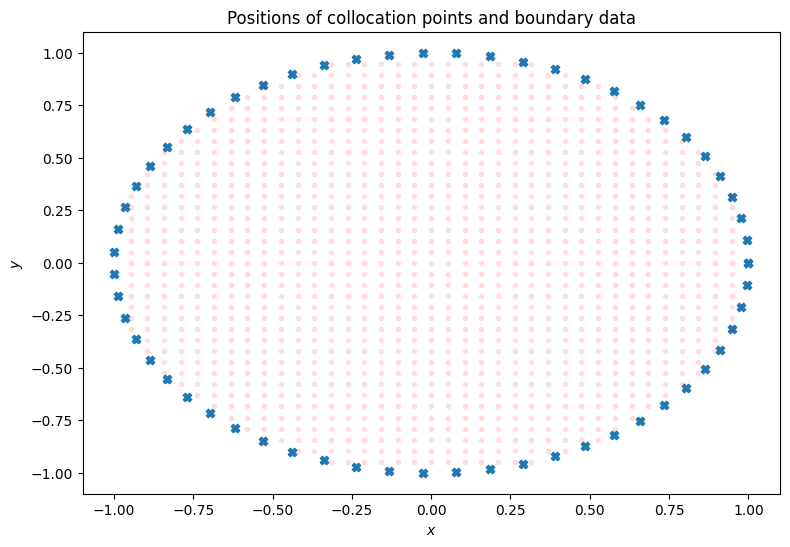

In [15]:
domain = ([-1,1],[-1,1])
PDE = PDE_Model()
domain = PDE.set_domain(domain)


lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1}

mesh = Mesh(domain, N_b=60, N_r=1500)
mesh.create_mesh(borders, ins_domain)
mesh.plot_points();


PINN_solver = PINN()
PINN_solver.adapt_PDE(PDE)

weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1
}

PINN_solver.adapt_mesh(mesh,**weights)

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_solver.create_NeuralNet(PINN_NeuralNet,lr=lr,**hyperparameters)



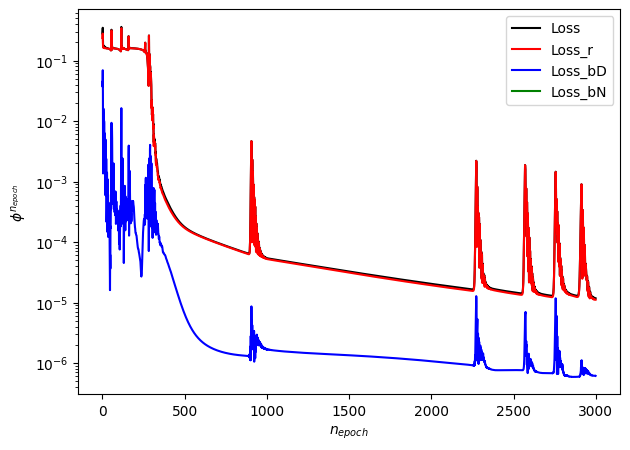

In [16]:
PINN_solver.solve(N=3000,flag_time=False)
PINN_solver.plot_loss_history();

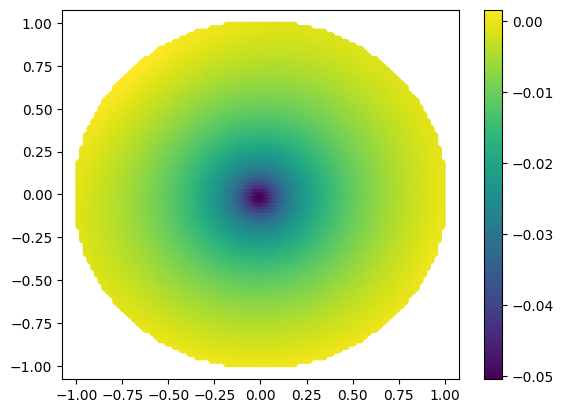

In [17]:
x,y,u = PINN_solver.get_u()

plt.scatter(x,y,c=u)
plt.colorbar();

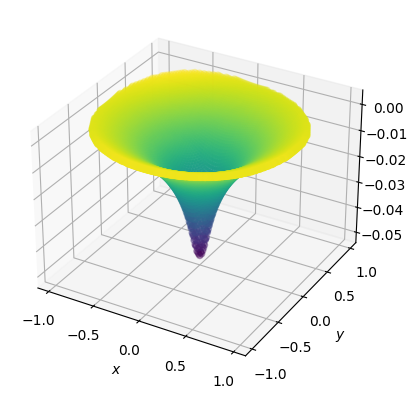

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,u, c=u)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

## Preconditioner

In [3]:
from classes.cartesian.preconditioner import preconditioner

precond = preconditioner()


In [4]:
domain = ([-1,1],[-1,1])

domain = precond.set_domain(domain)


lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1}

mesh = Mesh(domain, N_b=60, N_r=1500)
mesh.create_mesh(borders, ins_domain)

PINN_precond = PINN()

PINN_precond.adapt_mesh(mesh)

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape_N': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_precond.create_NeuralNet(PINN_NeuralNet,lr=lr,**hyperparameters)

PINN_precond.load_preconditioner(precond)

Tensor("pinn__neural_net/dense_8/BiasAdd:0", shape=(1125, 1), dtype=float32)
(1125, 1)
Tensor("pinn__neural_net/dense_8/BiasAdd:0", shape=(1125, 1), dtype=float32)
(1125, 1)


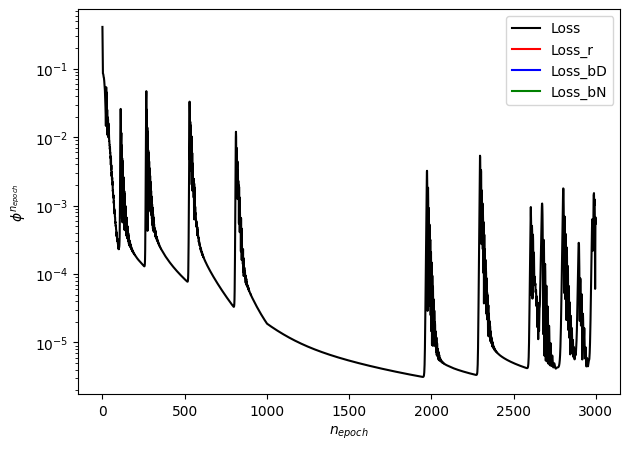

In [5]:
PINN_precond.preconditionate(N=3000,flag_time=False)
PINN_precond.plot_loss_history();

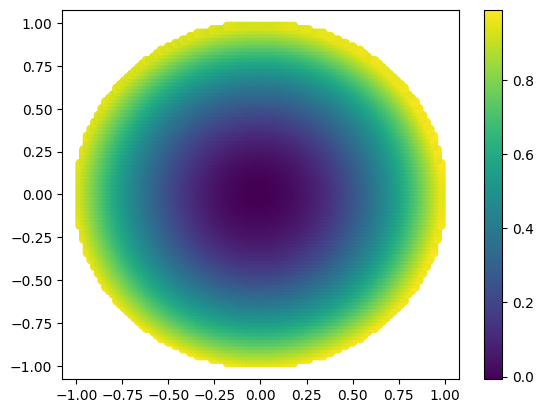

In [6]:
x,y,u = PINN_precond.get_u()

plt.scatter(x,y,c=u)
plt.colorbar();

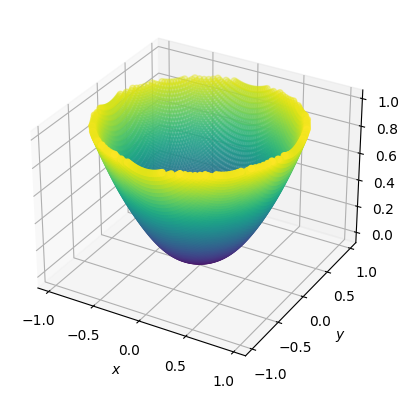

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,u, c=u)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [152]:
class PDE_Model2():

    def __init__(self):

        self.DTYPE='float32'
        self.pi = tf.constant(np.pi, dtype=self.DTYPE)
   
    def set_domain(self,X):
        x,y = X
        self.xmin = x[0]
        self.xmax = x[1]
        self.ymin = y[0]
        self.ymax = y[1]

        lb = tf.constant([self.xmin, self.ymin], dtype=self.DTYPE)
        ub = tf.constant([self.xmax, self.ymax], dtype=self.DTYPE)

        return (lb,ub)

    # Define boundary condition
    def fun_u_b(self,x, y, value):
        n = x.shape[0]
        return tf.ones((n,1), dtype=self.DTYPE)*value

    def fun_ux_b(self,x, y, value):
        n = x.shape[0]
        return tf.ones((n,1), dtype=self.DTYPE)*value

    # Define residual of the PDE
    def fun_r(self,x,y,u_x,u_xx,u_yy):
        return u_xx*x*x + u_x*x + u_yy

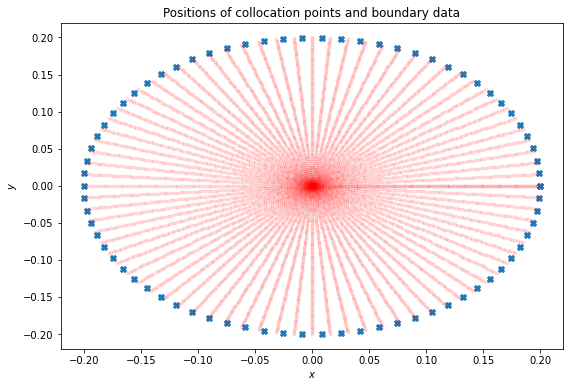

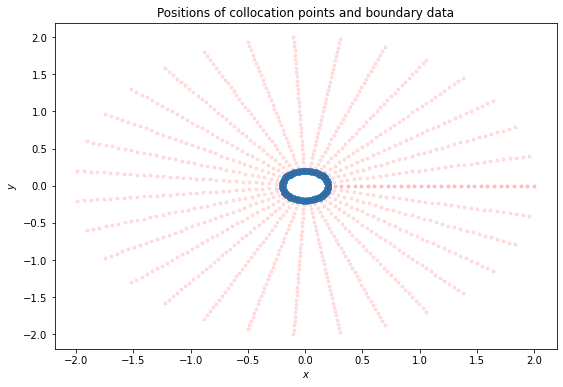

In [164]:
domain = ([0.001,0.2],[0,2*math.pi])
PDE1 = PDE_Model()
domain = PDE1.set_domain(domain)

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None,'r':0.2}
borders = {'1':lb}
mesh1 = Mesh(domain, N_b=300, N_r=80**2)
mesh1.create_mesh(borders)
mesh1.plot_points();

domain = ([0.2,2],[0,2*math.pi])
PDE2 = PDE_Model2()
domain = PDE2.set_domain(domain)

Ib = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':0.2}
#lb = {'type':'D', 'value':0, 'fun':None, 'dr':None,'r':8}
borders = dict()
borders['1'] = Ib
mesh2 = Mesh(domain, N_b=300, N_r=1000)
mesh2.create_mesh(borders)
mesh2.plot_points();

conds = (1,10)


In [165]:
res = mesh2.X_r

In [166]:
#solverx = XPINN(PINN_NeuralNet,(mesh1,mesh2),(PDE1,PDE2),conds)

In [167]:
solverx.solve(N=2000, flag_time=False)

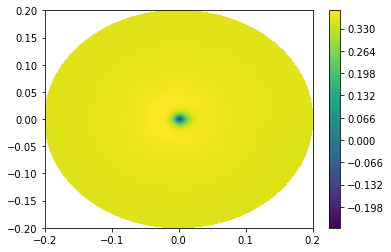

In [168]:
p1,p2 = solverx.get_u()
r,o,u1 = p1
x1 = r*np.cos(o)
y1 = r*np.sin(o)

r,o,u2 = p2
x2 = r*np.cos(o)
y2 = r*np.sin(o)

plt.contourf(x1,y1,u1,400)
plt.colorbar();



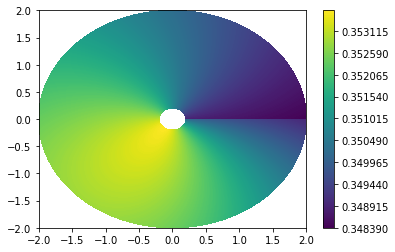

In [169]:
plt.contourf(x2,y2,u2,400)
plt.colorbar();

Text(0.5, 0, '$u_\\theta(t,x)$')

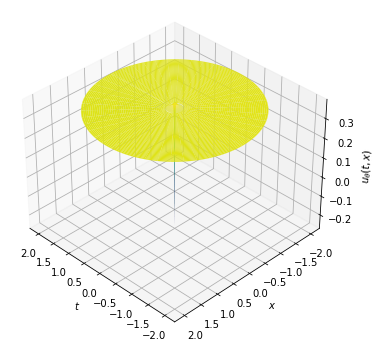

In [170]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

max_v = np.max(np.array([np.max(u1),np.max(u2)]))
min_v = np.min(np.array([np.min(u1),np.min(u2)]))

ax.plot_surface(x1, y1, u1, cmap=cm.viridis, vmin=min_v, vmax=max_v);
ax.plot_surface(x2, y2, u2,  cmap=cm.viridis, vmin=min_v, vmax=max_v);

ax.view_init(35,135)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')

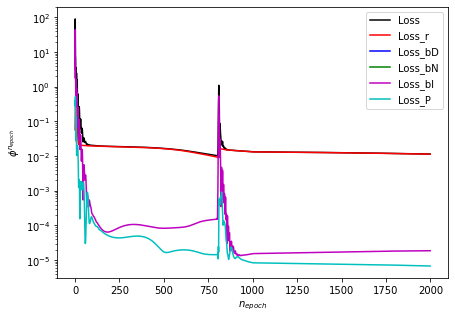

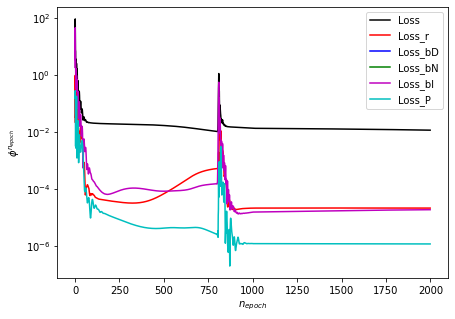

In [171]:
solverx.plot_loss_history1();
solverx.plot_loss_history2();